In [2]:
pip install --upgrade kagglehub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.4
    Uninstalling kagglehub-0.3.4:
      Successfully uninstalled kagglehub-0.3.4


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/covid-cxr-image-dataset-research")

print("Path to dataset files:", path)


100%|██████████| 572M/572M [00:08<00:00, 72.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1


In [4]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1"

# List all subfolders and files
for folder_name, subfolders, filenames in os.walk(dataset_path):
    print(f"Folder: {folder_name}")



Folder: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1
Folder: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE
Folder: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/normal
Folder: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/virus
Folder: /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/covid


In [5]:
#importing important libraries
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers
from google.colab import drive


# Loading images from Gdrive and creating directory per class
COV_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/covid"
NORM_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/normal"
VIR_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/virus"

# function for printing image specification
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

# function for getting image specification details
def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)


# getting specification of Normal images
Images_details(NORM_DIR)

# getting specification of COVID-19 images
Images_details(COV_DIR)

# getting specification of Viralimages
Images_details(VIR_DIR)

 ====== Images in:  /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/normal
images_count:	668
min_width:	1040
max_width:	2628
min_height:	650
max_height:	2628
 ====== Images in:  /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/covid
images_count:	536
min_width:	240
max_width:	4095
min_height:	237
max_height:	4095
 ====== Images in:  /root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/virus
images_count:	619
min_width:	384
max_width:	2304
min_height:	127
max_height:	2304


In [6]:
# Getting the list of images for each class for future use
Cimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORM_DIR)
Vimages = os.listdir(VIR_DIR)

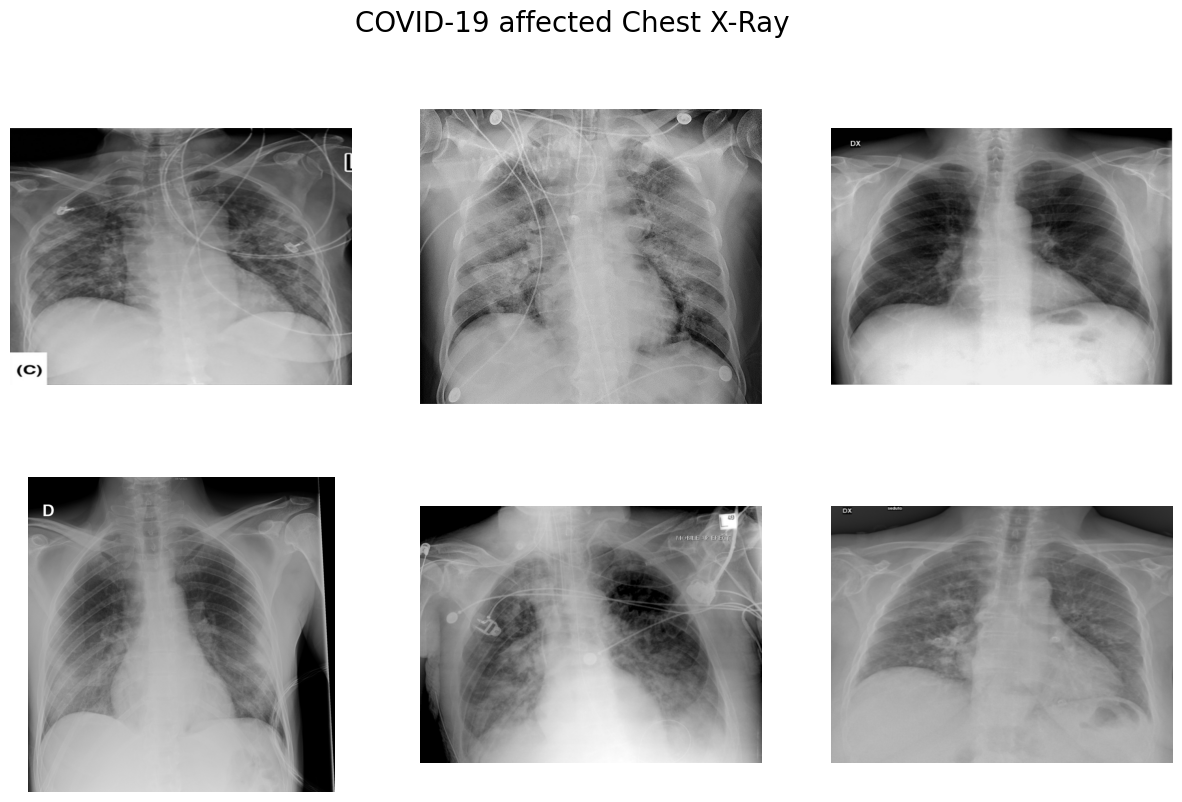

In [7]:
# Plotting sample images of COVID-19
sample_images = random.sample(Cimages, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
    im = cv2.imread(os.path.join(COV_DIR, sample_images[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')
f.suptitle('COVID-19 affected Chest X-Ray', fontsize=20)
plt.show()


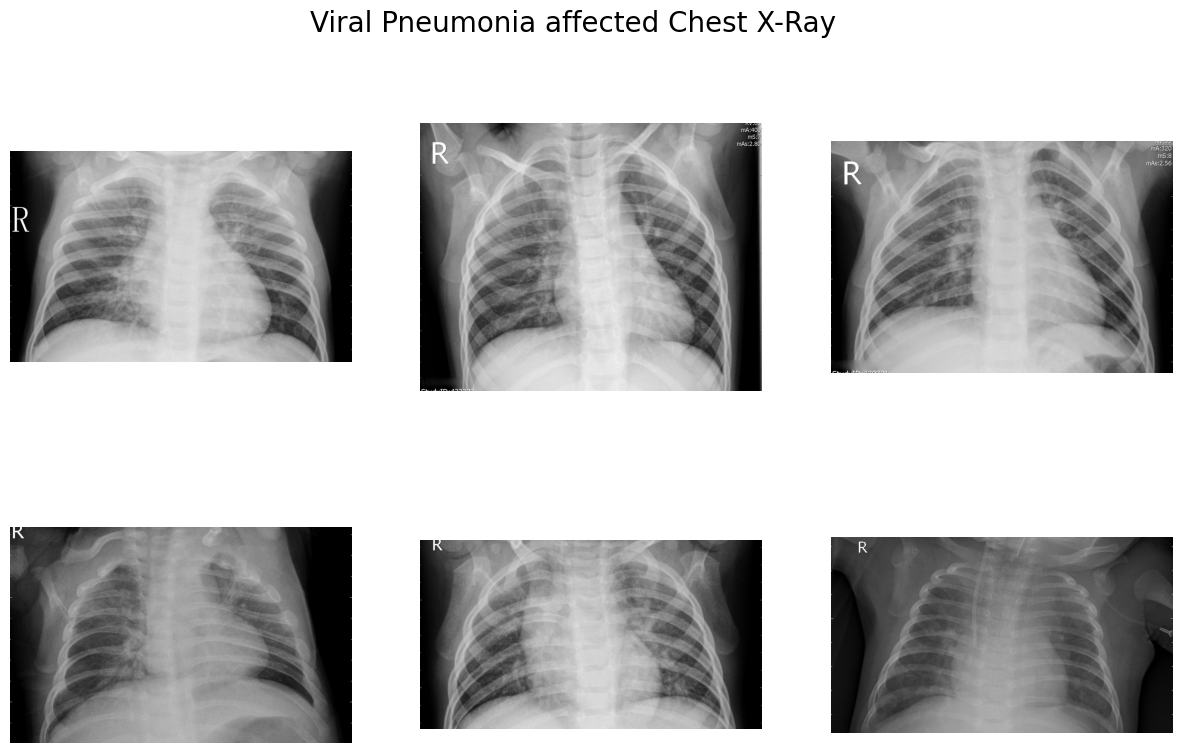

In [8]:
# Plotting sample images of Viral Pneumonia cases
sample_vimages = random.sample(Vimages, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
    im = cv2.imread(os.path.join(VIR_DIR, sample_vimages[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')
f.suptitle('Viral Pneumonia affected Chest X-Ray', fontsize=20)
plt.show()

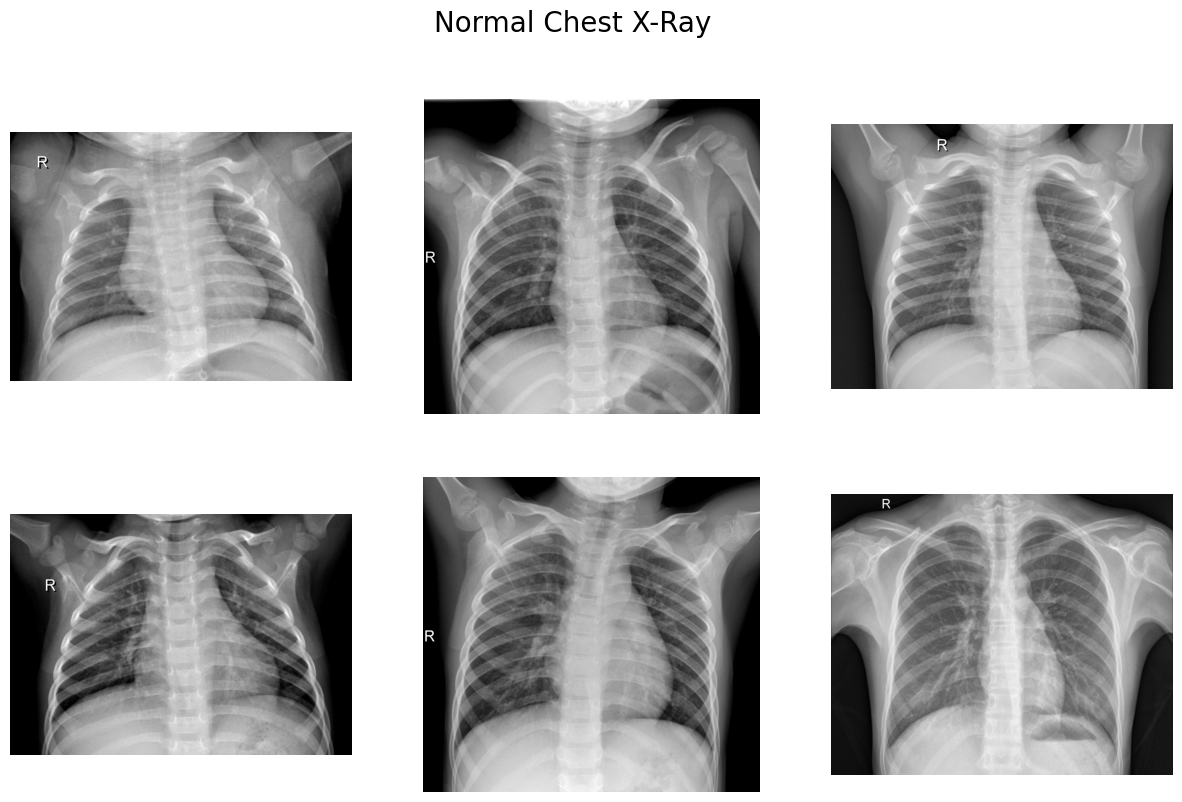

In [9]:
# Plotting sample images of Normal cases
sample_nimages = random.sample(Nimages, 6)
f, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
    im = cv2.imread(os.path.join(NORM_DIR, sample_nimages[i]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax[i // 3, i % 3].imshow(im)
    ax[i // 3, i % 3].axis('off')
f.suptitle('Normal Chest X-Ray', fontsize=20)
plt.show()

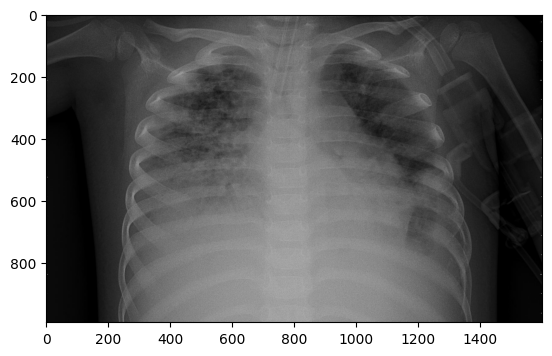

In [10]:
# Loading Original Image
img = cv2.imread('/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/virus/person1661_virus_2872.jpeg')
plt.imshow(img, cmap=plt.cm.bone)

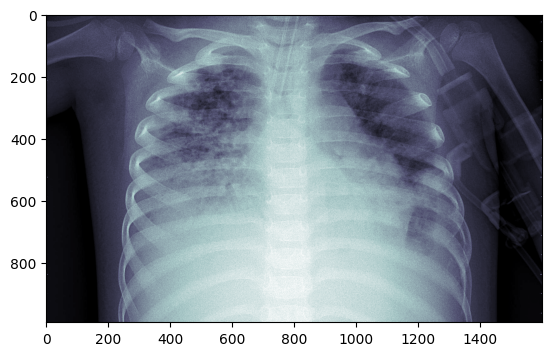

In [11]:
# white balance for every channel independently
def wb(channel, perc = 0.05):
    mi, ma = (np.percentile(channel, perc), np.percentile(channel,100.0-perc))
    channel = np.uint8(np.clip((channel-mi)*255.0/(ma-mi), 0, 255))
    return channel


imWB  = np.dstack([wb(channel, 0.05) for channel in cv2.split(img)] )
# Convert image to grayscale

gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap=plt.cm.bone)

In [12]:
data = []
labels = []

# Define the directories
NORMAL_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/normal/"
COVID_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/covid/"
VIRUS_DIR = "/root/.cache/kagglehub/datasets/sid321axn/covid-cxr-image-dataset-research/versions/1/COVID_IEEE/virus/"

# White balance function placeholder (replace with your implementation)
def wb(channel, percentage):
    # Perform white balance (placeholder logic)
    return channel

# Process images from each class
for a in os.listdir(NORMAL_DIR):
    image_path = os.path.join(NORMAL_DIR, a)
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip if the image could not be read
    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(img, (224, 224))
    data.append(resized_image)
    labels.append(0)

for b in os.listdir(COVID_DIR):
    image_path = os.path.join(COVID_DIR, b)
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip if the image could not be read
    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(img, (224, 224))
    data.append(resized_image)
    labels.append(1)

for c in os.listdir(VIRUS_DIR):
    image_path = os.path.join(VIRUS_DIR, c)
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip if the image could not be read
    imWB = np.dstack([wb(channel, 0.05) for channel in cv2.split(image)])
    gray_image = cv2.cvtColor(imWB, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    resized_image = cv2.resize(img, (224, 224))
    data.append(resized_image)
    labels.append(2)


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/My Drive/covid_dataset/feats_train",feats)
np.save("/content/drive/My Drive/covid_dataset/labels_train",labels)

In [15]:
# loading images
feats=np.load("/content/drive/My Drive/covid_dataset/feats_train.npy")
labels=np.load("/content/drive/My Drive/covid_dataset/labels_train.npy")

# randomizing the order of image and labels data
s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

# retaining length of the data and number of classes
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

1823


In [16]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [17]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by dividing 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [18]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

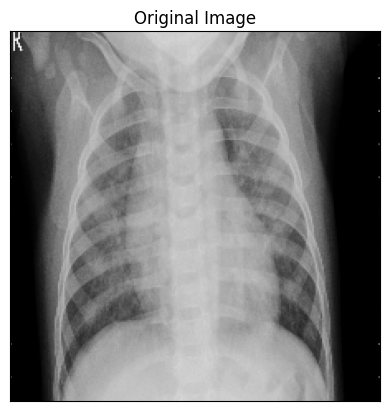

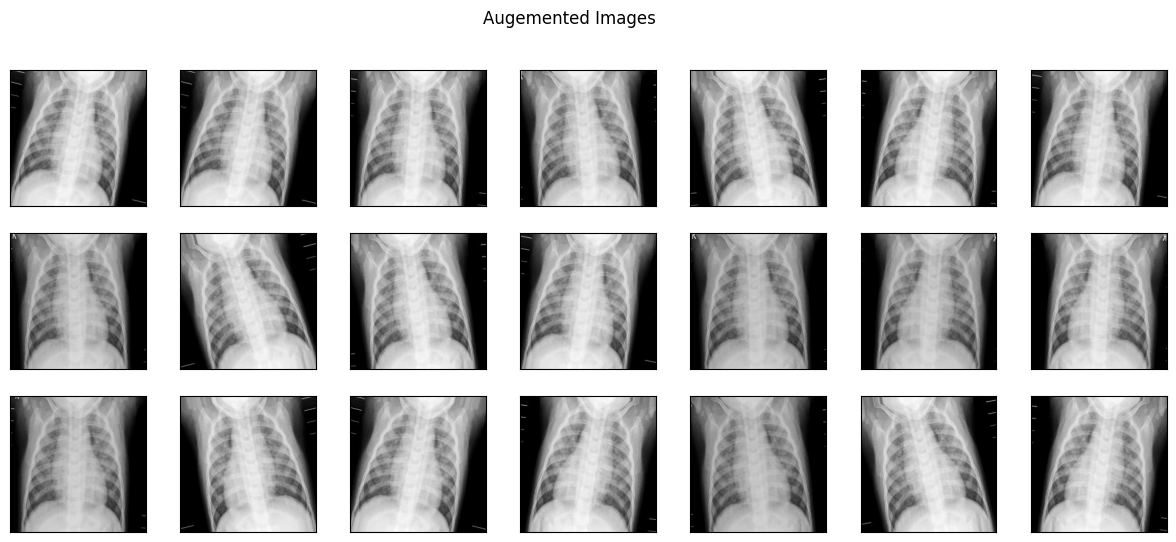

In [19]:
trainAug  = ImageDataGenerator(
    rotation_range=15,

    horizontal_flip=True,
    fill_mode="nearest")

# demo augmentation
# set the paramters we want to change randomly

import os

# Check if 'preview_1' directory exists
if not os.path.exists('preview_1'):
    os.mkdir('preview_1')

# Continue with your code to process images

x = x_train[1]
x = x.reshape((1,) + x.shape)

i = 0
for batch in trainAug.flow(x, batch_size=1, save_to_dir='preview_1', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 30:
        break

plt.imshow(x_train[1])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_1/'):
    img = cv2.imread('preview_1/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [20]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(conv_base.input, predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,989,955 (11.41 MB)

 Trainable params: 2,955,843 (11.28 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [22]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Setting callback functions
callbacks = [
    ModelCheckpoint('.mdl_wts_mobilenetv2.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)
]


In [23]:
# batch size
BS = 16
print("[INFO] training head...")
H = model.fit(
    trainAug.flow(x_train,y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=50,callbacks=callbacks)

[INFO] training head...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4167 - loss: 1.2739
Epoch 1: val_loss improved from inf to 6.46776, saving model to .mdl_wts_mobilenetv2.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 113s 593ms/step - accuracy: 0.4173 - loss: 1.2717 - val_accuracy: 0.2610 - val_loss: 6.4678 - learning_rate: 0.0010
Epoch 2/50
 1/91 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6250 - loss: 0.7736

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6250 - loss: 0.7736 - learning_rate: 0.0010
Epoch 3/50


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7077 - loss: 0.7381
Epoch 3: val_loss improved from 6.46776 to 1.41576, saving model to .mdl_wts_mobilenetv2.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.7080 - loss: 0.7378 - val_accuracy: 0.5000 - val_loss: 1.4158 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - accuracy: 0.8750 - loss: 0.3928 - learning_rate: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8110 - loss: 0.5470
Epoch 5: val_loss did not improve from 1.41576
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8113 - loss: 0.5467 - val_accuracy: 0.3571 - val_loss: 4.9412 - learning_rate: 0.0010
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.6293 - learning_rate: 0.0010
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8956 - loss: 0.3745
Epoch 7: val_loss did not improve from 1.41576

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000300

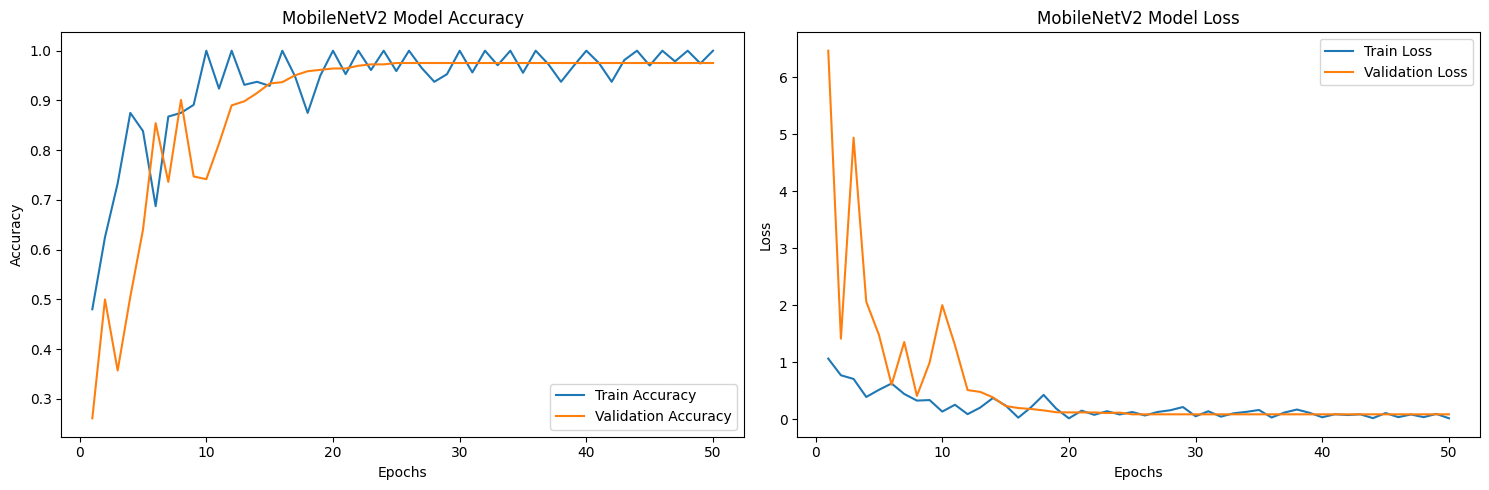

In [31]:
# Extract the metrics from the history object
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

# Ensure both training and validation accuracy/loss are of the same length
# This is necessary if the validation set was evaluated at fewer intervals
epochs_range = range(1, len(acc) + 1)  # Based on the training epochs

# If val_acc or val_loss has fewer values, repeat the last value to match the training epochs
if len(val_acc) < len(acc):
    val_acc = val_acc + [val_acc[-1]] * (len(acc) - len(val_acc))
    val_loss = val_loss + [val_loss[-1]] * (len(acc) - len(val_loss))

# Plotting
plt.figure(figsize=(15, 5))

# Plot accuracy for both training and validation
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNetV2 Model Accuracy')

# Plot loss for both training and validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNetV2 Model Loss')

plt.tight_layout()
plt.show()


In [35]:
model.save('.mdl_wts_mobilenetv2.hdf5')  # Save the model to a file


In [36]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('.mdl_wts_mobilenetv2.hdf5')

# Save the model to Google Drive
model.save('/content/drive/My Drive/covid_dataset/model_v1.h5')

# Reload the saved model from Google Drive
model = load_model('/content/drive/My Drive/covid_dataset/model_v1.h5')

# Checking the accuracy
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.9676 - loss: 0.0990

 Test_Accuracy:- 0.9752747416496277


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step


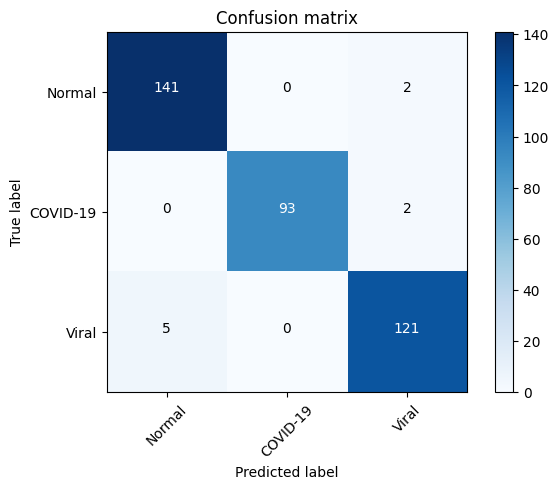

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','COVID-19','Viral']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis=1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)



# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [44]:
# If y_pred is shorter than y_true, truncate y_true to match y_pred's length
if len(y_true) > len(y_pred):
    y_true = y_true[:len(y_pred)]
elif len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]

# Now both arrays should have the same length
print(f"Adjusted Length of y_true: {len(y_true)}")
print(f"Adjusted Length of y_pred: {len(y_pred)}")

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=["Normal", "COVID-19", "Viral"])

# Print the report
print(report)


Adjusted Length of y_true: 356
Adjusted Length of y_pred: 356
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       108
    COVID-19       1.00      0.96      0.98       135
       Viral       0.93      1.00      0.97       113

    accuracy                           0.96       356
   macro avg       0.96      0.96      0.96       356
weighted avg       0.96      0.96      0.96       356



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


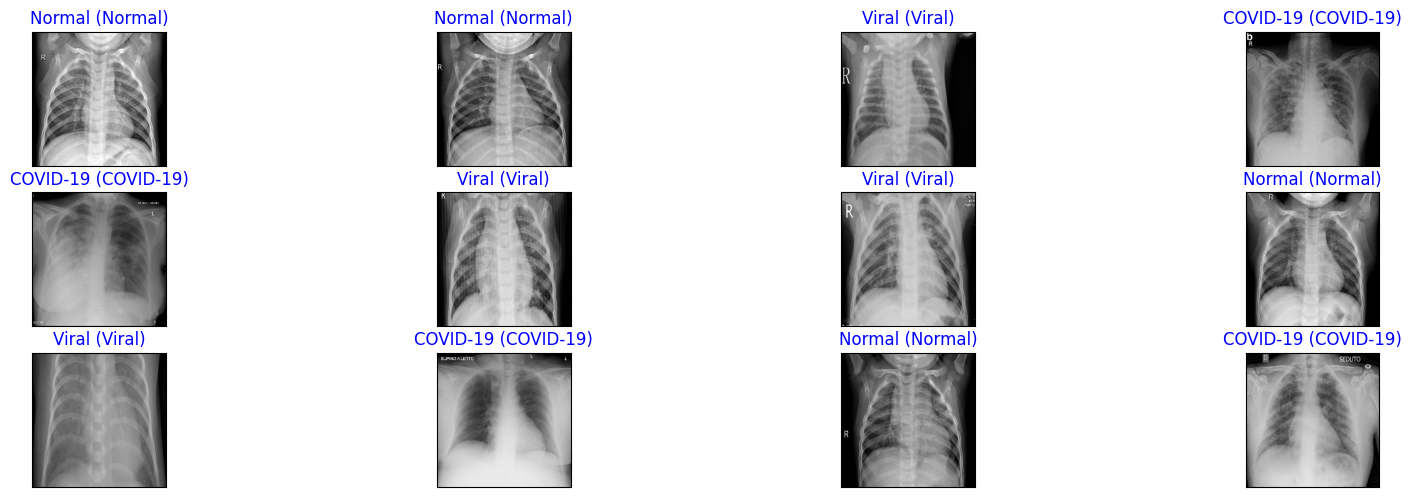

In [38]:
y_hat = model.predict(x_test)

# define text labels
cxr_labels = ['Normal','COVID-19','Viral']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cxr_labels[pred_idx], cxr_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))